# Figure 6

- Panel A: UMAP of Plate 6 single-cells using model feature space
- Panel B: PR curve of Plate 6
- Panel C: Accuracy bar plot of Plate 6

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


## Set paths

In [2]:
figure_dir <- "../figures"
output_main_figure_6 <- file.path(
    figure_dir, "main_figure_6_cell_line_generalizability.png"
)
results_dir <- file.path(
    "../../3.assess_generalizability/results"
)

## UMAP

In [3]:
# Path to UMAP results
UMAP_results_dir <- file.path(
    "/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/4.analyze_data/notebooks/UMAP/results"
)

# Load in platemap data to add Institution on to the UMAP results
platemap_df <- read.csv(
    "/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/0.download_data/metadata/platemap_NF1_plate6.csv"
)

# Subset the data frame and rename columns
platemap_df <- platemap_df[, c("well_position", "Institution")]
colnames(platemap_df) <- c("Metadata_Well", "Metadata_Institution")

# Load data
UMAP_results_file <- file.path(UMAP_results_dir, "UMAP_Plate_6_sc_only_model_features.tsv")

UMAP_results_df <- readr::read_tsv(UMAP_results_file)

# Merge institution info onto UMAP df
UMAP_results_df <- platemap_df %>% inner_join(UMAP_results_df, by = "Metadata_Well")

dim(UMAP_results_df)
head(UMAP_results_df)

Rows: 4695 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Metadata_Well, Metadata_genotype, Metadata_Plate
dbl (4): Metadata_Site, Metadata_number_of_singlecells, UMAP0, UMAP1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 4695    8

,Metadata_Well,Metadata_Institution,Metadata_Site,Metadata_number_of_singlecells,Metadata_genotype,Metadata_Plate,UMAP0,UMAP1
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,B2,iNFixion,32,129,WT,Plate_6_filtered,9.677656,2.548836
2,B2,iNFixion,27,129,WT,Plate_6_filtered,11.786816,2.142925
3,B2,iNFixion,6,129,WT,Plate_6_filtered,9.654215,2.353595
4,B2,iNFixion,15,129,WT,Plate_6_filtered,11.356328,1.135111
5,B2,iNFixion,17,129,WT,Plate_6_filtered,11.124468,1.591487
6,B2,iNFixion,22,129,WT,Plate_6_filtered,11.569425,2.243097


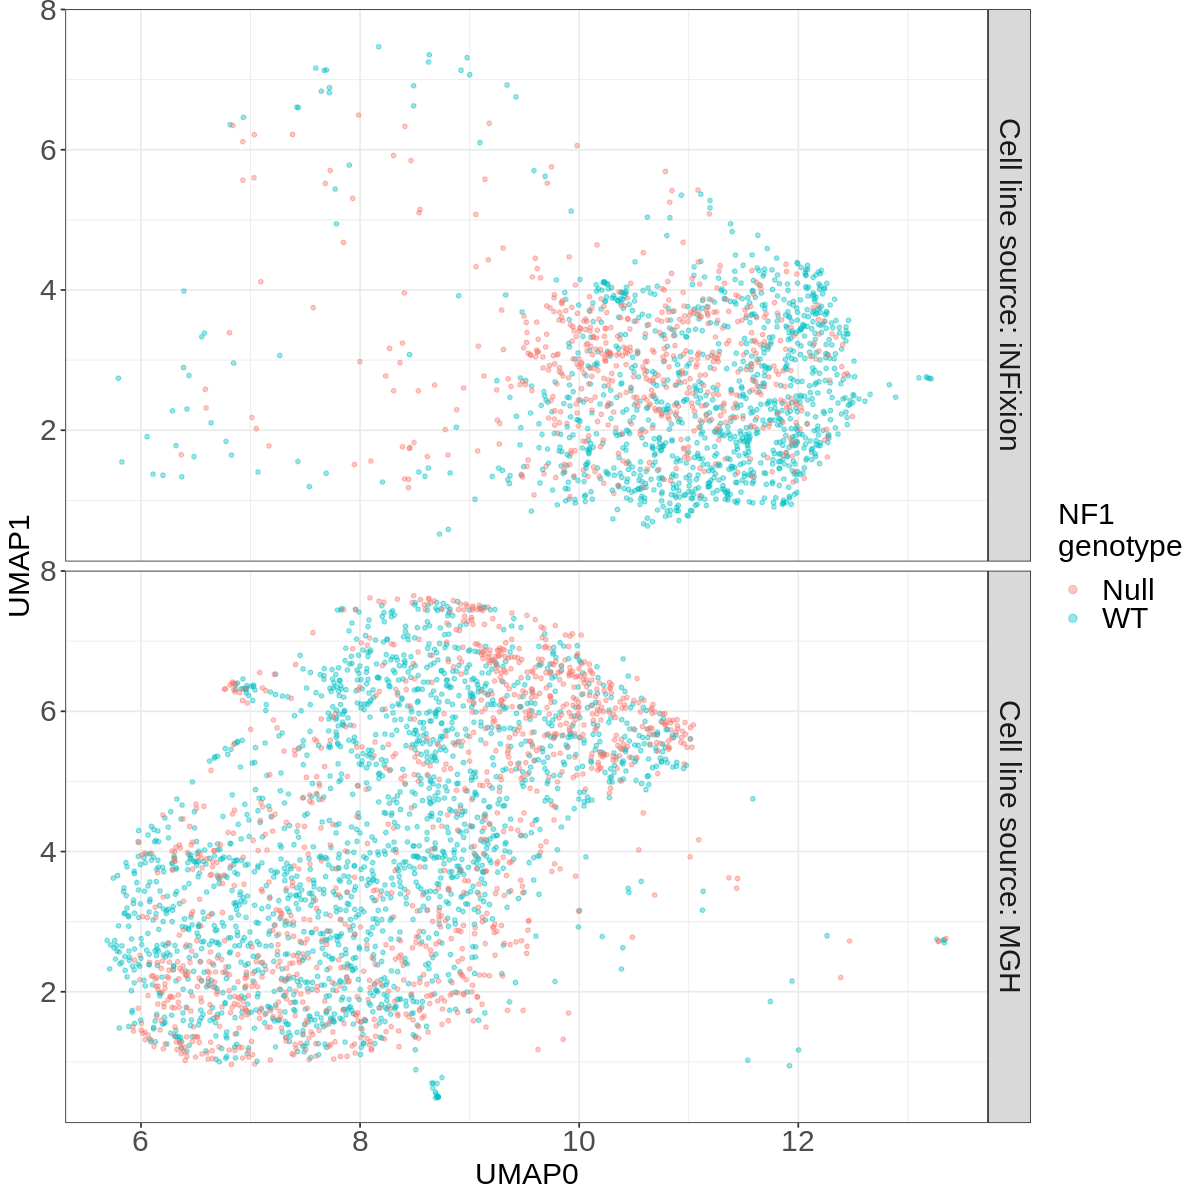

In [4]:
width <- 10
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

umap_fig_gg <- (
  ggplot(UMAP_results_df, aes(x = UMAP0, y = UMAP1))
  + geom_point(
      aes(color = Metadata_genotype),
      size = 1.0,
      alpha = 0.4
  )
  + theme_bw()
  + guides(
      color = guide_legend(
          override.aes = list(size = 2)
      )
  )
  + labs(x = "UMAP0", y = "UMAP1", color = "NF1\ngenotype")
  + facet_grid(Metadata_Institution ~ ., labeller = labeller(Metadata_Institution = function(x) paste("Cell line source:", x)))
  # change the text size
  + theme(
      strip.text = element_text(size = 18),
      # x and y axis text size
      axis.text.x = element_text(size = 18),
      axis.text.y = element_text(size = 18),
      # x and y axis title size
      axis.title.x = element_text(size = 18),
      axis.title.y = element_text(size = 18),
      # legend text size
      legend.text = element_text(size = 18),
      legend.title = element_text(size = 18)
  )
)

umap_fig_gg

## PR curve

In [5]:
# Load data (includes optimization in this file)
PR_results_file <- file.path(results_dir, "plate6_precision_recall_final_model.parquet")

PR_results_df <- arrow::read_parquet(PR_results_file)

# Create new column for model using the datasplit prefix
PR_results_df <- PR_results_df %>%
  mutate(shuffled_type = ifelse(grepl("^shuffled", data_type), "TRUE", "FALSE"))

dim(PR_results_df)
head(PR_results_df)

[1] 9127    5

Precision,Recall,Metadata_Institution,data_type,shuffled_type
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.6654088,1.0000000,iNFixion,final,FALSE
0.6658276,1.0000000,iNFixion,final,FALSE
0.6662469,1.0000000,iNFixion,final,FALSE
0.6660365,0.9990548,iNFixion,final,FALSE
0.6658260,0.9981096,iNFixion,final,FALSE
0.6656151,0.9971645,iNFixion,final,FALSE


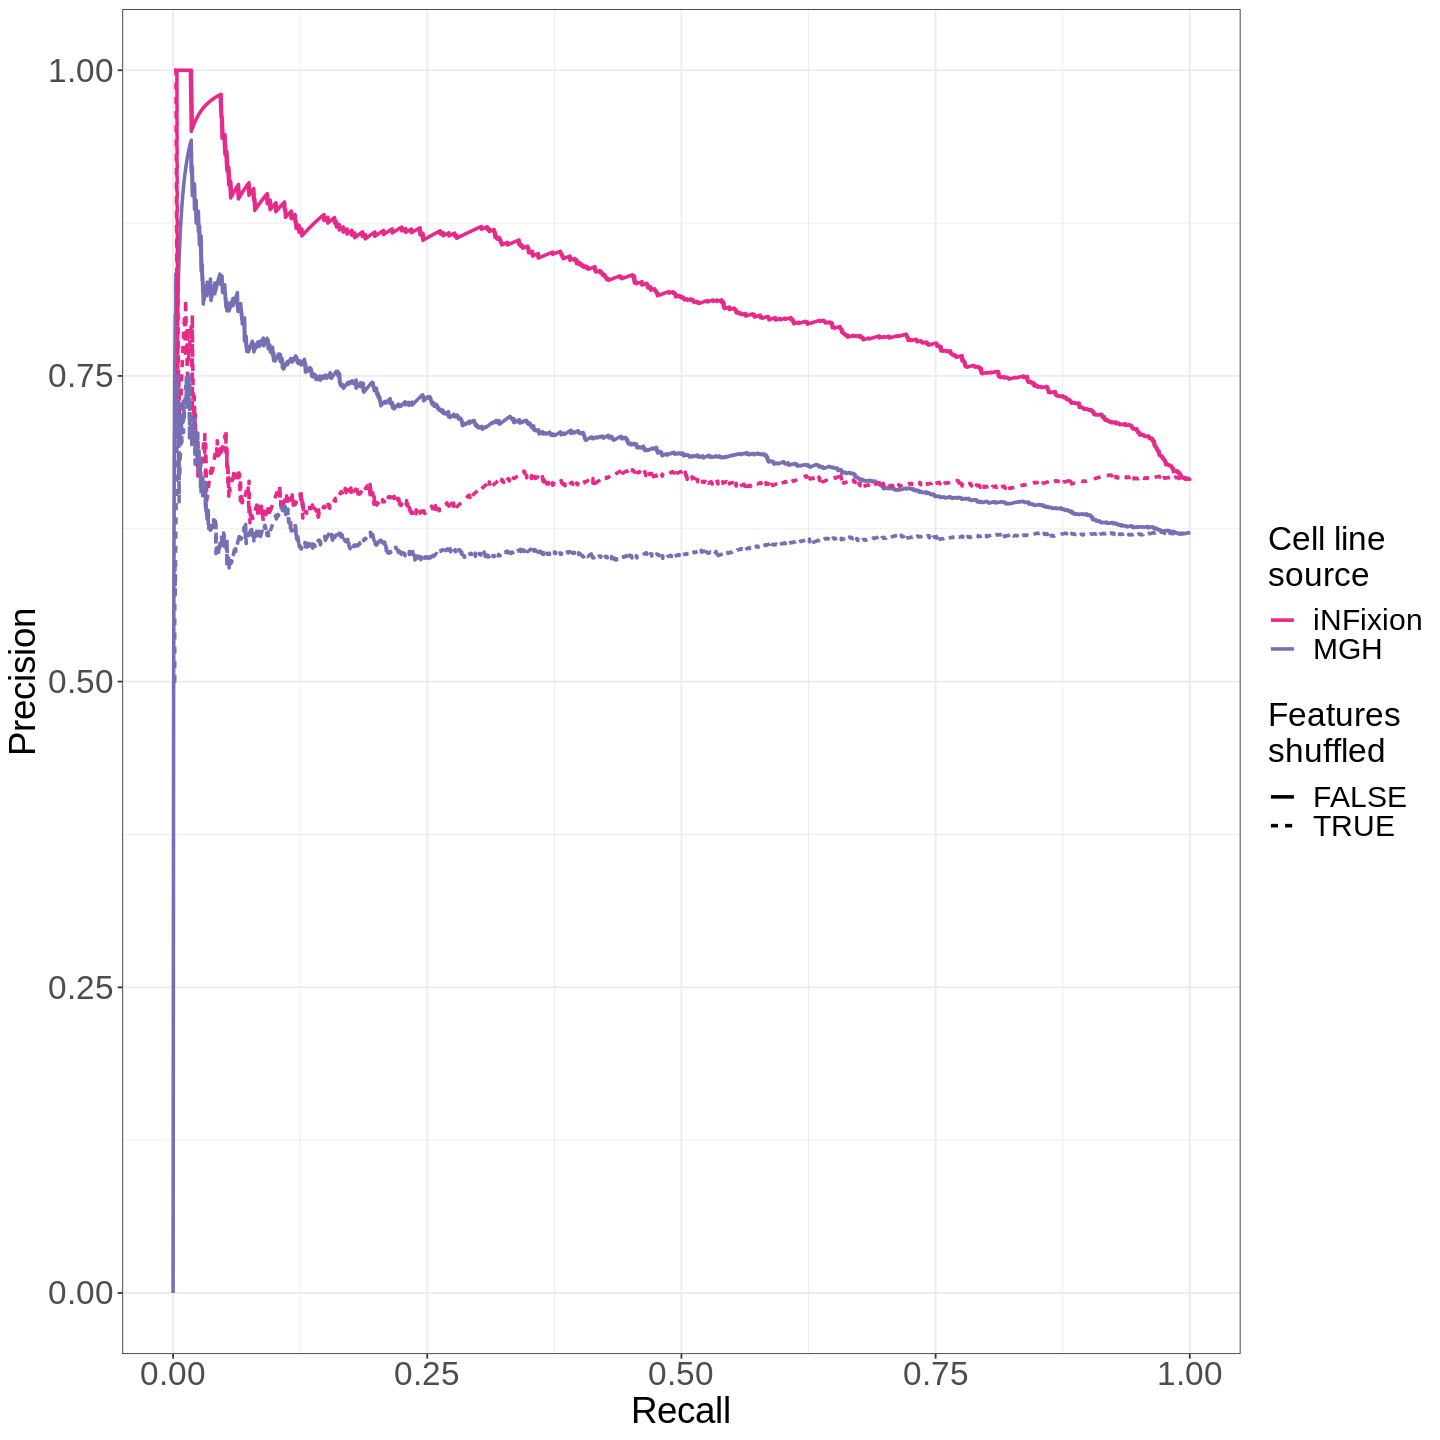

In [6]:
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

pr_curve_plot <- (
    ggplot(PR_results_df, aes(x = Recall, y = Precision, color = Metadata_Institution, linetype = shuffled_type))
    + geom_line(aes(linetype = shuffled_type), linewidth = 1)
    + theme_bw()
    # + coord_fixed()
    + labs(color = "Cell line\nsource", linetype = "Features\nshuffled", x = "Recall", y = "Precision")
    # change the colors
    + scale_color_manual(values = c(
        "iNFixion" = brewer.pal(8, "Dark2")[4],
        "MGH" = brewer.pal(8, "Dark2")[3]
    ))
    + scale_y_continuous(limits = c(0, 1))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))  
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 20),
    )
)

pr_curve_plot

## Accuracy bar plot

In [7]:
# Load data
accuracy_results_file <- file.path(results_dir, "plate6_accuracy_final_model.parquet")

accuracy_results_df <- arrow::read_parquet(accuracy_results_file)

# Create new column for model using the datasplit prefix
accuracy_results_df <- accuracy_results_df %>%
  mutate(shuffled_type = ifelse(grepl("^shuffled", data_type), "TRUE", "FALSE"))

dim(accuracy_results_df)
head(accuracy_results_df)

[1] 4 4

Metadata_Institution,data_type,accuracy,shuffled_type
<chr>,<chr>,<dbl>,<chr>
MGH,final,0.5875630,FALSE
MGH,shuffled,0.4917647,TRUE
iNFixion,final,0.6188679,FALSE
iNFixion,shuffled,0.5050314,TRUE


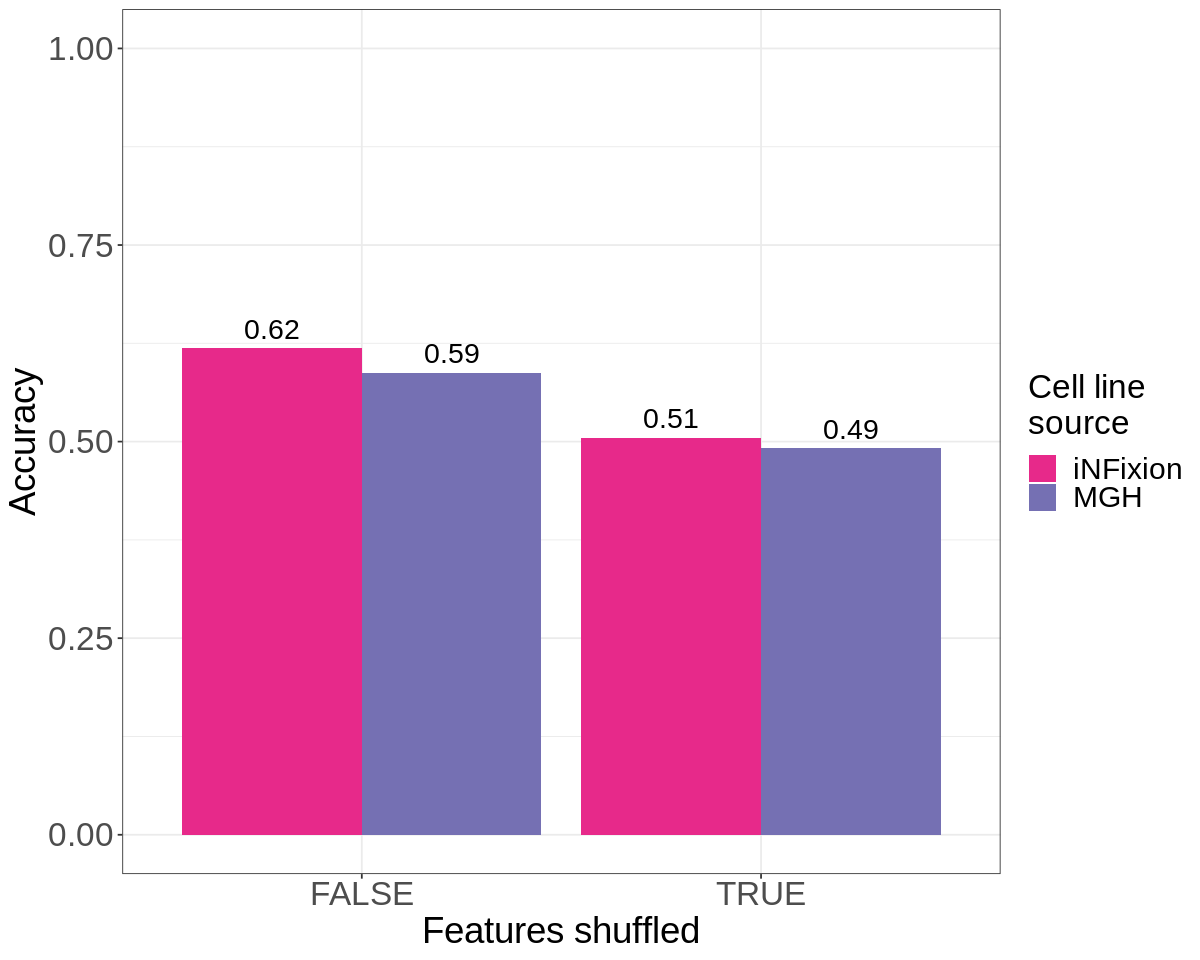

In [8]:
width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the accuracy scores
accuracy_score_plot <- (
    ggplot(accuracy_results_df, aes(x = shuffled_type, y = accuracy, fill = Metadata_Institution))
    + geom_bar(stat = "identity", position = "dodge")

    # Add text labels for accuracy scores on top of bars
    + geom_text(
        aes(label = sprintf("%.2f", accuracy)), 
        position = position_dodge(width = 0.9), 
        vjust = -0.5, 
        size = 6
    )

    + ylim(0, 1)
    + theme_bw()
    + ylab("Accuracy")
    + xlab("Features shuffled")
    # change the legend title
    + labs(fill = "Cell line\nsource")
    # change the colours
    + scale_fill_manual(values = c(
        "iNFixion" = brewer.pal(8, "Dark2")[4],
        "MGH" = brewer.pal(8, "Dark2")[3]
    ))
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 20),
    )
)

accuracy_score_plot

## Generate main figure 6

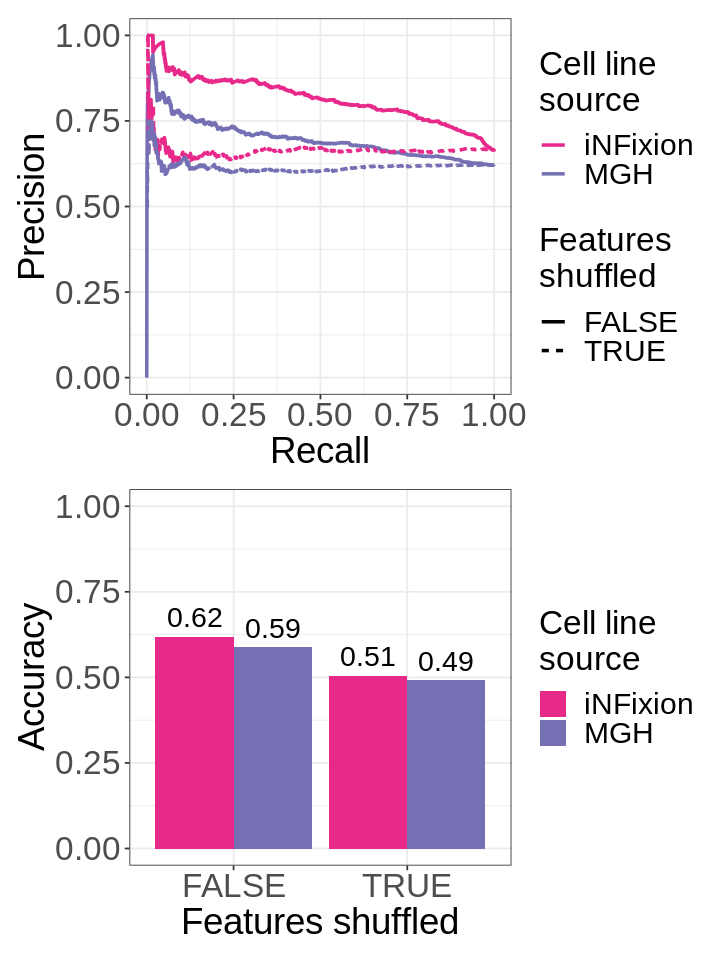

In [9]:
height <- 8
width <- 6
options(repr.plot.width = width, repr.plot.height = height)

right_plot <- (
    pr_curve_plot /
    accuracy_score_plot
) + plot_layout(heights = c(2,2))

right_plot

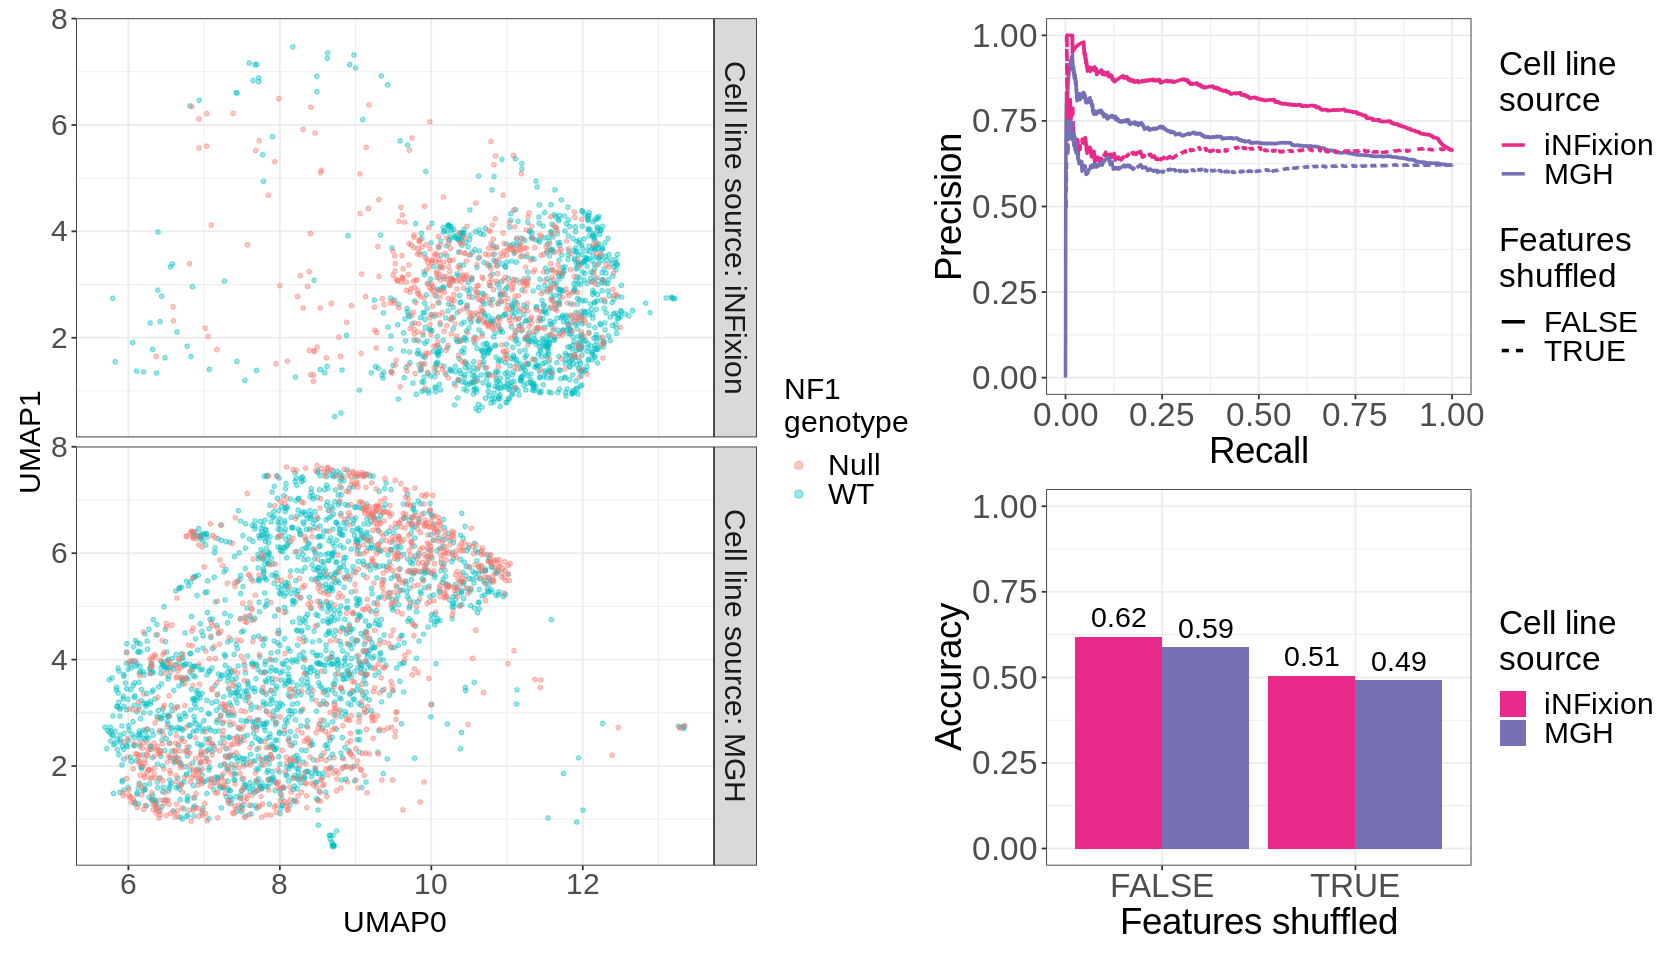

In [10]:
height <- 8
width <- 14
options(repr.plot.width = width, repr.plot.height = height)

align_plot <- (
    umap_fig_gg |
    right_plot
) + plot_layout(widths = c(3,2))

align_plot

In [11]:
fig_6_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save the plot
ggsave(output_main_figure_6, plot = fig_6_gg, dpi = 500, height = 8, width = 14)